# Amazon Food Reviews Sentiment Analysis

Automatic classification i.e. sentiment analysis of the dataset can be used by companies to assess user feedback on products in order to improve product quality, monitor brand reputation, monitor public response to launch of new products, provide personalized customer service etc.
This can also be used by the aggregator company i.e. Amazon, to provide personalized recommendations based to users based on their history and experience of the products.

## Import necessary libraries and read dataset

In [1]:
## Install required dependencies
!pip install -q contractions transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
## Mount google drive if running on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import word_tokenize
import contractions
import string

# Import sklearn related modules
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.dummy import DummyClassifier
from scipy.spatial.distance import cdist 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option('display.max_colwidth', None)

## Run this if the following nltk packages are not installed
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from gensim.parsing.preprocessing import remove_stopwords

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
## Read the amazon food reviews csv file
#rev_df = pd.read_csv('data/Reviews.csv')
rev_df = pd.read_csv('drive/MyDrive/Reviews.csv') # Run if running on colab
rev_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
## View information on the reviews dataset
rev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61946 entries, 0 to 61945
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      61946 non-null  int64 
 1   ProductId               61946 non-null  object
 2   UserId                  61946 non-null  object
 3   ProfileName             61943 non-null  object
 4   HelpfulnessNumerator    61946 non-null  int64 
 5   HelpfulnessDenominator  61946 non-null  int64 
 6   Score                   61946 non-null  int64 
 7   Time                    61946 non-null  int64 
 8   Summary                 61944 non-null  object
 9   Text                    61946 non-null  object
dtypes: int64(5), object(5)
memory usage: 4.7+ MB


In [6]:
rev_df[rev_df['ProfileName'].isnull()].head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
25509,25510,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
38874,38875,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...


In [7]:
rev_df["ProfileName"].fillna("John Doe", inplace = True) # Set null values as a default string

In [8]:
rev_df['ProfileName'].isnull().sum()

0

In [9]:
rev_df = rev_df.dropna()

In [10]:
rev_df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Data Preprocessing

### Remove duplicates

In [11]:
rev_df[rev_df.duplicated(subset=['ProductId','UserId','Summary','Text'])].shape

(79, 10)

In [12]:
rev_df = rev_df.drop_duplicates(subset=['ProductId','UserId','Summary','Text'], keep='first')

In [13]:
rev_df.shape

(61865, 10)

### Filter rows with helpfulness numerator <= helpfulness denominator

In [14]:
rev_df = rev_df[rev_df.HelpfulnessNumerator<=rev_df.HelpfulnessDenominator] ## Filter rows which have numerator lesser than denominator

In [15]:
rev_df.shape

(61864, 10)

### Mapping and Undersampling-by-Score

- Mapping ratings (1 to 5) to sentiment scores (0 to 2) as {1: 0, 2: 0, 3: 1, 4: 2, 5: 2} \\

- Undersampling from total dataset rows to 9990 rows with equal distribution of Sentiment Scores

In [16]:
rev_df['SentimentScore'] = rev_df['Score'].map({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

In [17]:
rev_df_sampled = rev_df.groupby(['SentimentScore'], group_keys=False).apply(lambda x: x.sample(3330, random_state=20))
rev_df_sampled.reset_index(drop=True, inplace=True)

In [18]:
rev_df_sampled.shape, rev_df_sampled.SentimentScore.value_counts()

((9990, 11), 0    3330
 1    3330
 2    3330
 Name: SentimentScore, dtype: int64)

In [19]:
# Combine Summary and Text Columns and drop columns
rev_df_sampled['SummaryTextCombined'] = rev_df_sampled['Summary'] + " " + rev_df_sampled['Text'] 
rev_df_sampled.drop(['Summary','Text'], axis=1, inplace=True)

### Text preprocessing 
- Remove HTML content, URLs, underscores, non-ascii, emails, hashtags, ampersand, newline and tab characters, words containing numbers, digits, brackets, punctuation, extra spaces 
- Expand contractions
- Convert string to lowercase

In [20]:
def expand_contractions(text):
    text = text.replace("’", "'").replace("‘", "'")
    text = text.replace("”", '"').replace("“", '"')
    return contractions.fix(text)

email_pattern = re.compile(r'\S+@\S+')
hashtags_pattern = re.compile(r'\#\w+')

# Remove HTML tags
rev_df_sampled['FinalText'] = rev_df_sampled['SummaryTextCombined'].apply(lambda x: BeautifulSoup(x,'lxml').get_text(" ", strip=True))
# Remove URLs
rev_df_sampled['FinalText'] =  rev_df_sampled['FinalText'].apply(lambda x: re.sub(r'http\S+',' ', str(x)))
# Remove underscore
rev_df_sampled['FinalText'] =  rev_df_sampled['FinalText'].apply(lambda x: re.sub(r'_',' ',str(x))) 
# Expand contractions
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].apply(expand_contractions)
# Remove non-ascii
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
# Remove emails
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].apply(lambda x: email_pattern.sub('', x))
# Remove hashtags
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].apply(lambda x: hashtags_pattern.sub('', x))
# Remove ampersand
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].replace('&amp;', '', regex=True)
# Remove newline and tab characters
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].replace('\n\t', ' ', regex=True)
# Remove words containing numbers
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].replace(r'\b\w*\d\w*\b', '', regex=True)
# Remove digits 
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].str.replace('\d+', '', regex=True)
# Remove brackets
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].str.replace(r'[\(\)\[\]\{\}]', ' ',regex=True)
# Remove punctuation
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].apply(lambda x:x.translate(str.maketrans("", "", string.punctuation+'”‘’“')))
# Remove extra spaces
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].replace('\s+', ' ', regex=True)
# Convert string to lowercase
rev_df_sampled['FinalText'] = rev_df_sampled['FinalText'].str.lower()

In [21]:
rev_df_sampled[['SummaryTextCombined','FinalText']].head()

,SummaryTextCombined,FinalText
0,"Doesn't taste like ""real"" peanut butter. I bou...",does not taste like real peanut butter i bough...
1,Stale! I was really excited to receive this pr...,stale i was really excited to receive this pro...
2,Taste like muddy water maybe because it is out...,taste like muddy water maybe because it is out...
3,Salmon Formula This smells more like cat food....,salmon formula this smells more like cat food ...
4,Over a dollar for a K-cup? The coffee is good ...,over a dollar for a kcup the coffee is good bu...


#### Remove stopwords

In [22]:
## Remove stopwords using gensim
rev_df_sampled['FinalText'] =  rev_df_sampled['FinalText'].apply(lambda x: remove_stopwords(x))

#### Tokenization and Lemmatization

In [23]:
def tokenize_lemmatize_text(text):
    tokenized_sent = word_tokenize(text)
    return " ".join([wordnet_lemmatizer.lemmatize(word) for word in tokenized_sent])

wordnet_lemmatizer = WordNetLemmatizer()
rev_df_sampled['FinalText'] =  rev_df_sampled['FinalText'].apply(lambda x: tokenize_lemmatize_text(x))

## Clustering using KMeans

In [24]:
def calc_distance(input_vec, centroids):
    return cosine_distances(input_vec, centroids)

### Step 0 - Feature extraction with TF-IDF Vectorization

In [25]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_vect.fit(rev_df_sampled["FinalText"])
final_tfidf = tfidf_vect.transform(rev_df_sampled["FinalText"])
print(final_tfidf.toarray().shape)

(9990, 5636)


### Step 1 - Pick k random "centroids"

In [26]:
def select_rand_centroids(input_vec, num_clusters):
    ## Choose centroid from document row
    idx = np.random.choice(len(input_vec), num_clusters, replace=False)
    # Select the centroid vectors from index
    centroids = input_vec[idx, :]
    return centroids

### Step 2 - Assign each vector to its closest centroid

In [27]:
def vect_assignment(input_vec,centroids):
    distances = calc_distance(input_vec, centroids)
    cluster_pts = np.array([np.argmin(i) for i in distances])
    return cluster_pts

### Step 3: Recalculate the centroids based on the closest vectors

In [28]:
def recalc_centroids(input_vec, num_clusters, cluster_pts):
    centroids = []
    for idx in range(num_clusters):
        #Updating Centroids by taking mean of Cluster it belongs to
        temp_cent = input_vec[cluster_pts==idx].mean(axis=0) 
        centroids.append(temp_cent)

    centroids = np.vstack(centroids)
    return centroids

### Main KMeans Clustering Function 

In [29]:
np.random.seed(5)
def kmeans_new(input_vec, num_clusters, niter):
    
    old_centroids = select_rand_centroids(input_vec, num_clusters)    
    cluster_pts = vect_assignment(input_vec,old_centroids)

    for iteration in range(niter): 
        new_centroids = recalc_centroids(input_vec, num_clusters, cluster_pts)
        centroid_dist = np.linalg.norm(new_centroids - old_centroids, 2)
        print("Centroid dist",centroid_dist)
        
        ## Break loop if no change in centroid updates
        if centroid_dist <= 0.001:
            print(f"Stopping at number of iterations - {iteration}")
            break
        
        old_centroids = new_centroids
        distances = calc_distance(input_vec, new_centroids)
        cluster_pts = np.array([np.argmin(i) for i in distances])

    return cluster_pts, new_centroids

cluster_pts, centroids = kmeans_new(final_tfidf.toarray(), 5, 50)

Centroid dist 0.9995134310779002
Centroid dist 0.1318012133345096
Centroid dist 0.04544669820667952
Centroid dist 0.02848816120478576
Centroid dist 0.026098959924332518
Centroid dist 0.026531287355323268
Centroid dist 0.030318871179048638
Centroid dist 0.028597434966549373
Centroid dist 0.018626733207345404
Centroid dist 0.01628455050263522
Centroid dist 0.017616148426449294
Centroid dist 0.02764038430387186
Centroid dist 0.03161941536209105
Centroid dist 0.011252493797709602
Centroid dist 0.016452524083238836
Centroid dist 0.026468600218424475
Centroid dist 0.02437917639843002
Centroid dist 0.015538884702647278
Centroid dist 0.00621465003936906
Centroid dist 0.004781330543040913
Centroid dist 0.004295408427627234
Centroid dist 0.0015750225690313888
Centroid dist 0.0007424775759312668
Stopping at number of iterations - 22


In [30]:
cluster_pts

array([3, 3, 3, ..., 1, 3, 0])

In [31]:
rev_df_sampled['cluster'] = cluster_pts

### Display the top keywords with their magnitudes and top representative documents for each cluster

In [32]:
for centroid_idx, centroid in enumerate(centroids):
    
    idx = np.argsort(-centroid)[:5]
    topktokens = [tfidf_vect.get_feature_names_out()[i] for i in idx]
    print("Cluster number =",centroid_idx)
    print("Top 5 tokens =>", topktokens)
    print("Magnitudes =>", centroid[idx])
    
    docs = rev_df_sampled[rev_df_sampled['cluster'] == centroid_idx]['FinalText'].iloc[:5].values 
    
    print()
    for doc in docs:
        print(f"|--", doc, "\n")

Cluster number = 0
Top 5 tokens => ['coffee', 'cup', 'roast', 'flavor', 'taste']
Magnitudes => [0.21986713 0.05528961 0.03734275 0.03472274 0.03385823]

|-- dollar kcup coffee good price ridiculous kcup approx green mountain cent kcup delivered buy cent kcup bed bath kohl 

|-- expected tully french roast favorite morning coffee supply unusually bitter buying locally smaller quantity feel dumped old product purchase likely toss advice buy nearer home check use date box come loose kcups inside date whatsoever 

|-- enjoy coffee probably taste like coffee flavorless saw good review thought couple box stuck bunch k cup want drink literally drink k cup tried fan k cup worst 

|-- stale flavor thought coffee mild earthy flavor recognize mildly stale happened ordering amazon read review indicating experienced brand coffee directly company check brewing date week buying local roaster 

|-- kcups properly sealed coffee inside box surprised opened box kcups properly sealed coffee spilled inside

### Confusion matrix between clusters and sentiment scores

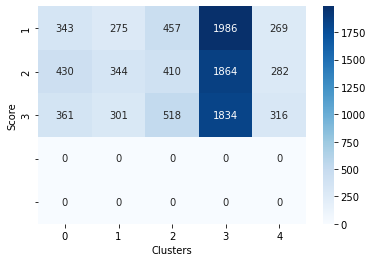

In [33]:
fig, ax = plt.subplots()
cm = confusion_matrix(rev_df_sampled['SentimentScore'].values + 1, cluster_pts+1)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Clusters')
plt.ylabel('Score')
ax.set_yticklabels([1,2,3,"",""])
plt.show()

### Confusion matrix between clusters and scores

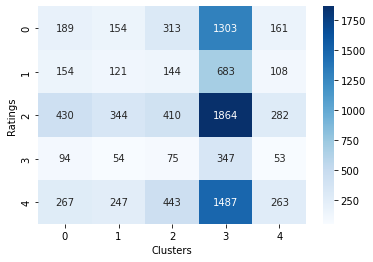

In [34]:
fig, ax = plt.subplots()
cm = confusion_matrix(rev_df_sampled['Score'].values, cluster_pts+1)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Clusters')
plt.ylabel('Ratings')
plt.show()

## Dataset split

In [35]:
X, y = rev_df_sampled["FinalText"], rev_df_sampled['SentimentScore']

In [36]:
y.value_counts()

0    3330
1    3330
2    3330
Name: SentimentScore, dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2, stratify=y_train)

In [38]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5994,), (5994,), (1998,), (1998,), (1998,), (1998,))

### Label Distribution

In [39]:
print("Target Labels Distribution")
train_dist = pd.DataFrame(y_train.value_counts()).reset_index().rename(columns={"index":"target_labels","SentimentScore":"label_counts"}).sort_values(by='target_labels')
train_dist["Set"] = "Train"
val_dist = pd.DataFrame(y_val.value_counts()).reset_index().rename(columns={"index":"target_labels","SentimentScore":"label_counts"}).sort_values(by='target_labels')
val_dist["Set"] = "Valid"
test_dist = pd.DataFrame(y_test.value_counts()).reset_index().rename(columns={"index":"target_labels","SentimentScore":"label_counts"}).sort_values(by='target_labels')
test_dist["Set"] = "Test"
final_dist = pd.concat([train_dist, val_dist, test_dist]) 
final_dist[["Set","label_counts","target_labels"]].reset_index(drop=True)

Target Labels Distribution


,Set,label_counts,target_labels
0,Train,1998,0
1,Train,1998,1
2,Train,1998,2
3,Valid,666,0
4,Valid,666,1
5,Valid,666,2
6,Test,666,0
7,Test,666,1
8,Test,666,2


## Classification

In [40]:
def format_3dec(val):
    formatted = "{:.3f}".format(val)
    return formatted

def get_classifier_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    return format_3dec(acc), format_3dec(precision), format_3dec(recall), format_3dec(f1)

### 1. Dummy classifier with strategy "most_frequent"

In [41]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_train_pred = dummy.predict(X_train)
y_pred = dummy.predict(X_val)

acc_dumfreq_trn, prec_dumfreq_trn, rec_dumfreq_trn, f1_dumfreq_trn = get_classifier_metrics(y_train, y_train_pred)
print("Training Classifier scores for most frequent dummy classifier: ",acc_dumfreq_trn, prec_dumfreq_trn, rec_dumfreq_trn, f1_dumfreq_trn)

acc_dumfreq, prec_dumfreq, rec_dumfreq, f1_dumfreq = get_classifier_metrics(y_val, y_pred)
print("Classifier scores for most frequent dummy classifier: ",acc_dumfreq, prec_dumfreq, rec_dumfreq, f1_dumfreq)

Training Classifier scores for most frequent dummy classifier:  0.333 0.111 0.333 0.167
Classifier scores for most frequent dummy classifier:  0.333 0.111 0.333 0.167


### 2. Dummy classifier with strategy "stratified"

In [42]:
dummy_strat = DummyClassifier(strategy="stratified")
dummy_strat.fit(X_train, y_train)

y_train_pred = dummy_strat.predict(X_train)
y_pred = dummy_strat.predict(X_val)

acc_dumstrat_trn, prec_dumstrat_trn, rec_dumstrat_trn, f1_dumstrat_trn = get_classifier_metrics(y_train, y_train_pred)
print("Training Classifier scores for stratified dummy classifier: ",acc_dumstrat_trn, prec_dumstrat_trn, rec_dumstrat_trn, f1_dumstrat_trn)

acc_dumstrat, prec_dumstrat, rec_dumstrat, f1_dumstrat = get_classifier_metrics(y_val, y_pred)
print("Classifier scores for stratified dummy classifier: ",acc_dumstrat, prec_dumstrat, rec_dumstrat, f1_dumstrat)

Training Classifier scores for stratified dummy classifier:  0.337 0.337 0.337 0.337
Classifier scores for stratified dummy classifier:  0.332 0.332 0.332 0.332


### 3. LogisticRegression with One-hot vectorization

In [43]:
onehotenc = CountVectorizer(binary=True)
X_train_one_hot = onehotenc.fit_transform(X_train)
X_val_one_hot = onehotenc.transform(X_val)

log_reg = LogisticRegression()
log_reg.fit(X_train_one_hot, y_train)

y_train_pred = log_reg.predict(X_train_one_hot)
y_pred = log_reg.predict(X_val_one_hot)

acc_logonehot_trn, prec_logonehot_trn, rec_logonehot_trn, f1_logonehot_trn = get_classifier_metrics(y_train, y_train_pred)
print("Training Classifier scores for most frequent dummy classifier: ",acc_logonehot_trn, prec_logonehot_trn, rec_logonehot_trn, f1_logonehot_trn)

acc_logonehot, prec_logonehot, rec_logonehot, f1_logonehot = get_classifier_metrics(y_val, y_pred)
print("Classifier scores for logistic regression (onehot) classifier: ",acc_logonehot, prec_logonehot, rec_logonehot, f1_logonehot)

Training Classifier scores for most frequent dummy classifier:  0.988 0.988 0.988 0.988
Classifier scores for logistic regression (onehot) classifier:  0.653 0.652 0.653 0.652


### 4. LogisticRegression with TFIDF vectorization

In [44]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

y_train_pred = log_reg.predict(X_train_tfidf)
y_pred = log_reg.predict(X_val_tfidf)

acc_logtfidf_trn, prec_logtfidf_trn, rec_logtfidf_trn, f1_logtfidf_trn = get_classifier_metrics(y_train, y_train_pred)
print("Training Classifier scores for most frequent dummy classifier: ",acc_logtfidf_trn, prec_logtfidf_trn, rec_logtfidf_trn, f1_logtfidf_trn)

acc_logtfidf, prec_logtfidf, rec_logtfidf, f1_logtfidf = get_classifier_metrics(y_val, y_pred)
print("Classifier scores for logistic regression (tfidf) classifier: ",acc_logtfidf, prec_logtfidf, rec_logtfidf, f1_logtfidf)

Training Classifier scores for most frequent dummy classifier:  0.878 0.878 0.878 0.878
Classifier scores for logistic regression (tfidf) classifier:  0.684 0.686 0.684 0.685


### 5. SVC (RBF Kernel) with Onehot vectorization

In [45]:
onehotenc = CountVectorizer(binary=True)
X_train_one_hot = onehotenc.fit_transform(X_train)
X_val_one_hot = onehotenc.transform(X_val)

svc = SVC(kernel='rbf')
svc.fit(X_train_one_hot, y_train)

y_train_pred = svc.predict(X_train_one_hot)
y_pred = svc.predict(X_val_one_hot)

acc_svc_trn, prec_svc_trn, rec_svc_trn, f1_svc_trn = get_classifier_metrics(y_train, y_train_pred)
print("Training Classifier scores for most frequent dummy classifier: ",acc_svc_trn, prec_svc_trn, rec_svc_trn, f1_svc_trn)

acc_svc, prec_svc, rec_svc, f1_svc = get_classifier_metrics(y_val, y_pred)
print("Classifier scores for logistic regression (tfidf) classifier: ",acc_svc, prec_svc, rec_svc, f1_svc)

Training Classifier scores for most frequent dummy classifier:  0.934 0.934 0.934 0.934
Classifier scores for logistic regression (tfidf) classifier:  0.669 0.673 0.669 0.670


### Classifier Models Comparison Table

In [46]:
metrics = ["Accuracy", "MacroAvg_Precision", "MacroAvg_Recall", "MacroAvg_F1Score"]

dumfreq_dict = {
    "Model":"Dummy_MostFrequent",
    "Metrics":metrics,
    "Training_Set": [acc_dumfreq_trn, prec_dumfreq_trn, rec_dumfreq_trn, f1_dumfreq_trn],
    "Validation_Set" : [acc_dumfreq, prec_dumfreq, rec_dumfreq, f1_dumfreq]
}

dumstrat_dict = {
    "Model":"Dummy_Stratified",
    "Metrics":metrics,
    "Training_Set": [acc_dumstrat_trn, prec_dumstrat_trn, rec_dumstrat_trn, f1_dumstrat_trn],
    "Validation_Set" : [acc_dumstrat, prec_dumstrat, rec_dumstrat, f1_dumstrat]
}

logregonehot_dict = {
    "Model":"LogisticReg_OneHot",
    "Metrics":metrics,
    "Training_Set": [acc_logonehot_trn, prec_logonehot_trn, rec_logonehot_trn, f1_logonehot_trn],
    "Validation_Set" : [acc_logonehot, prec_logonehot, rec_logonehot, f1_logonehot]
}

logregtfidf_dict = {
    "Model":"LogisticReg_TFIDF",
    "Metrics":metrics,
    "Training_Set": [acc_logtfidf_trn, prec_logtfidf_trn, rec_logtfidf_trn, f1_logtfidf_trn],
    "Validation_Set" : [acc_logtfidf, prec_logtfidf, rec_logtfidf, f1_logtfidf]
}

svc_dict = {
    "Model":"SVC_RBF",
    "Metrics":metrics,
    "Training_Set": [acc_svc_trn, prec_svc_trn, rec_svc_trn, f1_svc_trn],
    "Validation_Set" : [acc_svc, prec_svc, rec_svc, f1_svc]
}

a = pd.DataFrame(dumfreq_dict)
b = pd.DataFrame(dumstrat_dict)
c = pd.DataFrame(logregonehot_dict)
d = pd.DataFrame(logregtfidf_dict)
e = pd.DataFrame(svc_dict)

clf_comp_df = pd.concat([a,b,c,d,e]).reset_index(drop=True)
clf_comp_df

,Model,Metrics,Training_Set,Validation_Set
0,Dummy_MostFrequent,Accuracy,0.333,0.333
1,Dummy_MostFrequent,MacroAvg_Precision,0.111,0.111
2,Dummy_MostFrequent,MacroAvg_Recall,0.333,0.333
3,Dummy_MostFrequent,MacroAvg_F1Score,0.167,0.167
4,Dummy_Stratified,Accuracy,0.337,0.332
5,Dummy_Stratified,MacroAvg_Precision,0.337,0.332
6,Dummy_Stratified,MacroAvg_Recall,0.337,0.332
7,Dummy_Stratified,MacroAvg_F1Score,0.337,0.332
8,LogisticReg_OneHot,Accuracy,0.988,0.653
9,LogisticReg_OneHot,MacroAvg_Precision,0.988,0.652


- The best classifier by Macro F1 on validation set = **Logistic Regression with TFIDF Vectorization**

### Class-wise F1 Score Plot for best classifier baseline model

In [47]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

y_pred = log_reg.predict(X_val_tfidf)

precision, recall, f1_score_classwise, support = precision_recall_fscore_support(y_val, y_pred, average=None)

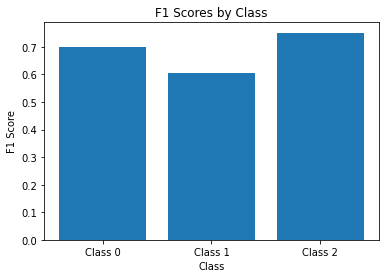

In [48]:
labels = ['Class 0', 'Class 1', 'Class 2']
plt.bar(labels, f1_score_classwise)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Class')

plt.show()

### Own Classifier - SVC RBF Classifier with TF-IDF Vectorization

In [49]:
vectorizer = TfidfVectorizer(binary=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [50]:
param_grid = {
    'C': [0.01, 0.1, 1, 5], # Regularization Parameter
    'gamma': [0.1, 1, 5] # Smoothness of decision boundary
}

svc = SVC(kernel='rbf', class_weight='balanced')

grid_search = GridSearchCV(svc, param_grid, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)

y_pred_trn = grid_search.predict(X_train_tfidf)
y_pred = grid_search.predict(X_val_tfidf)

acc_rftfidf_trn, prec_rftfidf_trn, rec_rftfidf_trn, f1_rftfidf_trn = get_classifier_metrics(y_train, y_pred_trn)
print("Training Classifier scores for linear SVC classifier: ",acc_rftfidf_trn, prec_rftfidf_trn, rec_rftfidf_trn, f1_rftfidf_trn)

acc_rftfidf, prec_rftfidf, rec_rftfidf, f1_rftfidf = get_classifier_metrics(y_val, y_pred)
print("Validation Classifier scores for linear SVC classifier: ",acc_rftfidf, prec_rftfidf, rec_rftfidf, f1_rftfidf)

Best parameters: {'C': 1, 'gamma': 1}
Training Classifier scores for linear SVC classifier:  0.988 0.988 0.988 0.988
Validation Classifier scores for linear SVC classifier:  0.683 0.686 0.683 0.684


## Parameter Tuning

In [51]:
parameters = {
    'vect__sublinear_tf': [True, False],
    'vect__max_features': [None, 1000, 10000, 50000],
    'vect__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'clf__penalty': ['l1', 'l2'],
    #'clf__max_iter': [100, 200]
}

In [52]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

grid_search = GridSearchCV(pipeline, parameters, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_val)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__sublinear_tf': True}


In [53]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__sublinear_tf': True}


In [54]:
grid_search.best_score_

0.6936948013160661

In [55]:
acc_logtfidf, prec_logtfidf, rec_logtfidf, f1_logtfidf = get_classifier_metrics(y_val, y_pred)
print("Classifier scores for logistic regression (tfidf) classifier: ",acc_logtfidf, prec_logtfidf, rec_logtfidf, f1_logtfidf)

Classifier scores for logistic regression (tfidf) classifier:  0.688 0.689 0.688 0.689


## Context Vectors using BERT

### Import related libraries

In [56]:
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import RobertaModel, RobertaTokenizerFast
from transformers import TrainingArguments, Trainer
from transformers import set_seed, pipeline
from datasets import Dataset
import torch

## Set seed to replicate results
set_seed(42)

In [57]:
X_train_bert = X_train.reset_index(drop=True)
y_train_bert = y_train.reset_index(drop=True)
X_val_bert = X_val.reset_index(drop=True)
y_val_bert = y_val.reset_index(drop=True)

### Initialize Roberta Tokenizer and Model

In [58]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Create feature extraction pipeline, generate embeddings for each data record and append to list

In [59]:
# Create the feature-extraction pipeline
feature_extractor = pipeline("feature-extraction", model=model, tokenizer=tokenizer)

# Encode the training and validation data
X_trnembeddings = []
y_trnlst = []
X_valembeddings = []
y_vallst = []

for X_traindoc, y_label in zip(X_train_bert, y_train_bert):

    trn_encoded = feature_extractor(X_traindoc, max_length=512, padding=True, truncation=True)
    frst_contextvec = np.array(trn_encoded[0][0])
    X_trnembeddings.append(frst_contextvec)
    y_trnlst.append(y_label)
    
print("Training done")
        
for X_valdoc, y_vallabel in zip(X_val_bert, y_val_bert):
    val_encoded = feature_extractor(X_valdoc, max_length=512, padding=True, truncation=True)
    frst_contextvec_val = np.array(val_encoded[0][0])
    X_valembeddings.append(frst_contextvec_val)
    y_vallst.append(y_vallabel)

print("Evaluation done")

Training done
Evaluation done


### Train logistic regression model with embeddings and get validation metrics

In [60]:
clf = LogisticRegression()
clf.fit(X_trnembeddings, y_trnlst)

LogisticRegression()

In [61]:
y_pred = clf.predict(X_valembeddings)

acc_val, prec_val, rec_val, f1_val = get_classifier_metrics(y_vallst, y_pred)
print("Logistic Regression Classifier scores: ",acc_val, prec_val, rec_val, f1_val)

Logistic Regression Classifier scores:  0.651 0.648 0.651 0.649


### End-to-end Roberta Model

In [62]:
import gc
gc.collect()
torch.cuda.memory_allocated()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [63]:
from transformers import AutoModelForSequenceClassification
from transformers import RobertaModel, RobertaTokenizerFast
from transformers import TrainingArguments, Trainer
from transformers import set_seed, pipeline
from datasets import Dataset
import torch

## Set seed to replicate results
set_seed(42)

In [64]:
## Create BERT-specific dataframe to be transformed into a Dataset object
train_df_bert = pd.DataFrame({'text':X_train, 'label':y_train})
val_df_bert = pd.DataFrame({'text':X_val, 'label':y_val})
X_train_df = Dataset.from_pandas(train_df_bert)
X_val_df = Dataset.from_pandas(val_df_bert)

In [65]:
## Compute metrics function for transformers trainer function
def compute_metrics(pred):
    metrics_dict = {}
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    metrics_dict =  {'accuracy': accuracy,'precision': precision,'recall': recall,'f1': f1}
    return metrics_dict

### Tokenize dataset

In [66]:
def preprocess_data(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512, padding="max_length")

train_Dataset_tokenized = X_train_df.map(preprocess_data, batched=True)
val_Dataset_tokenized = X_val_df.map(preprocess_data, batched=True)

Map:   0%|          | 0/5994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

### Retrain Roberta Model

In [67]:
# Load the Roberta tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

training_args = TrainingArguments(
    output_dir="roberta_textclf",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16, 
    num_train_epochs=1, 
    weight_decay=0, 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_Dataset_tokenized, 
    eval_dataset=val_Dataset_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.099624,0.333333,0.111111,0.333333,0.166667


TrainOutput(global_step=375, training_loss=1.10506005859375, metrics={'train_runtime': 160.9875, 'train_samples_per_second': 37.233, 'train_steps_per_second': 2.329, 'total_flos': 1577101825861632.0, 'train_loss': 1.10506005859375, 'epoch': 1.0})

### Hyperparameter Tuning

#### Case 1

In [68]:
learning_rate = 1e-5
batch_size = 24
epochs = 7

In [77]:
training_args = TrainingArguments(
    output_dir="roberta_textclf",
    evaluation_strategy="epoch",
    learning_rate=learning_rate, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_Dataset_tokenized, 
    eval_dataset=val_Dataset_tokenized, 
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.981441,0.685686,0.697989,0.685686,0.686566
2,No log,0.916348,0.699199,0.701806,0.699199,0.698917
3,0.378200,0.922641,0.700701,0.703096,0.700701,0.700547


TrainOutput(global_step=501, training_loss=0.3780139236750003, metrics={'train_runtime': 434.7122, 'train_samples_per_second': 41.365, 'train_steps_per_second': 1.152, 'total_flos': 4731305477584896.0, 'train_loss': 0.3780139236750003, 'epoch': 3.0})

### Case 2

In [78]:
learning_rate = 2e-5
batch_size = 32
epochs = 4

In [79]:
training_args = TrainingArguments(
    output_dir="roberta_textclf",
    evaluation_strategy="epoch",
    learning_rate=learning_rate, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_Dataset_tokenized, 
    eval_dataset=val_Dataset_tokenized, 
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.074965,0.673674,0.688993,0.673674,0.668556
2,No log,1.008735,0.689189,0.706539,0.689189,0.692467
3,0.354700,0.981673,0.691191,0.704276,0.691191,0.694793
4,0.354700,1.050980,0.696196,0.704946,0.696196,0.698206


TrainOutput(global_step=752, training_loss=0.32234488142297624, metrics={'train_runtime': 592.4579, 'train_samples_per_second': 40.469, 'train_steps_per_second': 1.269, 'total_flos': 6308407303446528.0, 'train_loss': 0.32234488142297624, 'epoch': 4.0})

### Case 3

In [80]:
learning_rate = 1.5e-5
batch_size = 36
epochs = 3

In [81]:
training_args = TrainingArguments(
    output_dir="roberta_textclf",
    evaluation_strategy="epoch",
    learning_rate=learning_rate, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_Dataset_tokenized, 
    eval_dataset=val_Dataset_tokenized, 
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.254452,0.700701,0.708498,0.700701,0.702241
2,No log,1.213646,0.696196,0.710969,0.696196,0.699664
3,0.195000,1.254698,0.697197,0.706992,0.697197,0.699623


TrainOutput(global_step=501, training_loss=0.1946814854419279, metrics={'train_runtime': 435.6399, 'train_samples_per_second': 41.277, 'train_steps_per_second': 1.15, 'total_flos': 4731305477584896.0, 'train_loss': 0.1946814854419279, 'epoch': 3.0})

## Testing using best model

The BERT model having the following parameters is yielding the best evaluation metrics:
- learning_rate = 1.5e-5
- batch_size = 36
- epochs = 1

In [82]:
test_df_bert = pd.DataFrame({'text':X_test, 'label':y_test})
X_test_df = Dataset.from_pandas(test_df_bert)
test_Dataset_tokenized = X_test_df.map(preprocess_data, batched=True)

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

In [83]:
learning_rate = 1.5e-5
batch_size = 36
epochs = 1

In [84]:
training_args = TrainingArguments(
    output_dir="roberta_textclf",
    evaluation_strategy="epoch",
    learning_rate=learning_rate, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_Dataset_tokenized, 
    eval_dataset=test_Dataset_tokenized, 
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.477902,0.686186,0.693396,0.686186,0.688612


TrainOutput(global_step=167, training_loss=0.14612379473840406, metrics={'train_runtime': 144.139, 'train_samples_per_second': 41.585, 'train_steps_per_second': 1.159, 'total_flos': 1577101825861632.0, 'train_loss': 0.14612379473840406, 'epoch': 1.0})

In [85]:
# Perform prediction on test dataset
y_pred_test, label_ids, metrics = trainer.predict(test_Dataset_tokenized)

In [90]:
## Get the class with the highest predicion score
y_pred_test = y_pred_test.argmax(-1)

In [91]:
y_pred_test

array([0, 1, 0, ..., 0, 2, 2])

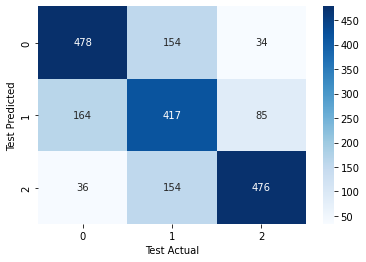

In [92]:
# Plot confusion matrix
fig, ax = plt.subplots()
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Test Actual')
plt.ylabel('Test Predicted')
plt.show()